In [ ]:
import json
import warnings
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

## Этап 1 - Получение текстового описания дисциплины

**Прочитаем данные**

In [ ]:
discipline_data_original = pd.read_csv("D:/Data/df_up_courses_202308.csv", dtype={"unit_id": int})
discipline_data_original.drop(columns=["Unnamed: 0"], inplace=True)
display(discipline_data_original.shape)
display(discipline_data_original.sample(3))

(1039709, 11)

,course_id,course_title,description,section,topic,qualification,unit_id,up_id,up_title,start_year,module_name
795602,14014,Дискретная математика,Цель изучения дисциплины – формирование систем...,Теория множеств,Бинарные отношения,bachelor,2,6971,Цифровые системы управления,2020,Модуль обязательных дисциплин
57860,12158,Эмоциональный интеллект / Emotional Intelligence,Emotional intelligence (EI) is a key leadershi...,Social skills,Non-verbal communication and congruence.,master,22,6993,Технологии разработки компьютерных игр,2020,Элективная дисциплина Soft Skills
62834,13950,Основы организации международных научных иссле...,International Research Management Essentials (...,Project Management Tools,Expert judgement,master,22,7067,Веб-технологии,2020,Элективная дисциплина Soft Skills


**Найдём сущности у которых совпадает раздел и тема**

In [ ]:
duplicate_items_indexes = discipline_data_original.query("section == topic").index.to_list()
print(duplicate_items_indexes[:5])
print(len(duplicate_items_indexes))

[1362, 1363, 1364, 1365, 1366]
6308


**Объединим колонки с информацией о дисциплине**

In [ ]:
def concat_description_columns(row: pd.Series) -> str:
    return f'{row["description"]} {" ".join({row["section"], row["topic"]})}'

In [ ]:
discipline_data = discipline_data_original.copy()
discipline_data["full_description"] = discipline_data.apply(concat_description_columns, axis=1)
discipline_data.sample(3)[["course_title", "full_description"]]

,course_title,full_description
1012114,Перевод в сфере профессиональной коммуникации,"Факультатив предназначен для тех, кто хочет на..."
187254,Система синергетического развития ресурсов тел...,FLS(FutureLifeStyle) – это система синергетиче...
492341,Первичная обработка данных и Хранение больших ...,Дисциплина состоит из двух разделов: \n1) Разд...


**Проверим работу на дубликатах**

In [ ]:
discipline_data.iloc[1362][["course_title", "full_description"]]

course_title                                Численные методы фотоники
full_description    Данный курс представляет собой совокупность об...
Name: 1362, dtype: object

**Выкинем ненужные колонки**

In [ ]:
discipline_data.drop(columns=["description", "topic", "section"], inplace=True)

**Сохраним данные**

In [ ]:
discipline_data.to_csv("D:/Data/discipline_data_step_1.csv", sep=";", index=False, encoding="utf-8")

## Этап 2 - Предобработаем полное описание дисциплины

In [ ]:
discipline_data = pd.read_csv("D:/Data/discipline_data_step_1.csv", sep=";", encoding="utf-8")

In [ ]:
from ml_data_engine import DataProcessor, YAMLConfigParser

**Предобработаем данные с помощью написанного мной пакета**

Шаги:
1. Нижний регистр
2. Удаление цифр
3. Лемматизация
4. Удаление стоп-слов
5. Удаление спец-символов
6. Удаление лишних пробелов

In [ ]:
dp = DataProcessor(YAMLConfigParser("../configs/preprocessing.yaml"))

In [ ]:
discipline_data = dp.process_dataframe_text(discipline_data, ["full_description"])

In [ ]:
discipline_data.sample(3)

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,full_description
806394,22685,Сложная коммуникация,All_levels,22,7146,Программирование и интернет-технологии,2021,Общеуниверситетские факультативы,стратегический уровень курс помогать обучаться...
268726,11543,Жизнь в науке: путеводитель молодого исследова...,master,22,7045,Городское планирование и городской дизайн,2020,Элективная дисциплина Soft Skills,the online course life in science a guide for ...
312387,14575,Когнитивные инструменты принятия решений,bachelor,22,6945,Цифровое производство,2019,Элективная дисциплина Soft Skills (выбор 2-х д...,цель курс формирование студент общий представл...


**Сохраним данные**

In [ ]:
discipline_data.to_csv("D:/Data/discipline_data_step_2.csv", sep=";", index=False, encoding="utf-8")

## Этап 3 - Обучим модель Word2Vec

In [ ]:
discipline_data = pd.read_csv("D:/Data/discipline_data_step_2.csv", sep=";", encoding="utf-8")

**Токенизируем полное описание для обучения Word2Vec**

In [ ]:
discipline_data["tokenized_description"] = discipline_data.full_description.apply(word_tokenize)

In [ ]:
discipline_data.sample(3)

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,full_description,tokenized_description
953270,24153,Компиляторы,master,49,7176,Разработка программного обеспечения / Software...,2022,Дисциплины по выбору 2,данный курс представлять начальный введение об...,"[данный, курс, представлять, начальный, введен..."
594444,2769,Информационная безопасность,bachelor,12,6878,Нейротехнологии и программирование,2018,Факультетский модуль,курс рассматриваться основной положение информ...,"[курс, рассматриваться, основной, положение, и..."
399438,15935,Курс по переводу / Translation and Interpretin...,All_levels,9,6894,Цифровой электропривод робототехнических компл...,2018,Факультативные дисциплины,курс интересоваться межкультурный коммуникация...,"[курс, интересоваться, межкультурный, коммуник..."


**Сохраним данные**

In [ ]:
discipline_data.to_csv("D:/Data/discipline_data_step_3.csv", sep=";", index=False, encoding="utf-8")

**Загрузим данные**

In [ ]:
discipline_data = pd.read_csv("D:/Data/discipline_data_step_3.csv", sep=";", encoding="utf-8")

In [ ]:
word2vec_model = Word2Vec(discipline_data.tokenized_description, min_count=1, vector_size=300, workers=4, window=10)

In [ ]:
model_path = "../models/word2vec_07032024.model"
word2vec_model.save(model_path)

In [ ]:
word2vec_model = Word2Vec.load("../models/word2vec_07032024.model")

In [ ]:
word2vec_model.wv.most_similar(["машинный", "обучение"])

[('регрессия', 0.36459454894065857),
 ('бустинг', 0.35472044348716736),
 ('гоморь', 0.35027945041656494),
 ('покрывать', 0.3501035273075104),
 ('байесовский', 0.3483789563179016),
 ('прогонка', 0.3346691429615021),
 ('многокритериальный', 0.33082443475723267),
 ('трехдиагональный', 0.32724204659461975),
 ('ax', 0.3268941044807434),
 ('численный', 0.32662850618362427)]

**Создадим метод для получения среднего вектора**

In [ ]:
def vectorize(sentence: List[str], word2vec_model: Word2Vec) -> List[float]:
    if not sentence:
        return np.zeros(word2vec_model.vector_size).tolist()

    if not (vectors := [word2vec_model.wv[token] for token in sentence if token in word2vec_model.wv]):
        return np.zeros(word2vec_model.vector_size).tolist()

    return np.mean(vectors, axis=0).tolist()

In [ ]:
vectorize(discipline_data.iloc[0].tokenized_description, word2vec_model)

[2.011167049407959,
 -0.7231157422065735,
 0.4870200455188751,
 0.5072075724601746,
 -0.765300452709198,
 -1.6194796562194824,
 0.7530128359794617,
 0.9735105037689209,
 0.5314057469367981,
 1.19530189037323,
 -0.4714702069759369,
 0.22545677423477173,
 -1.8648070096969604,
 -0.4779071807861328,
 2.2759623527526855,
 -0.7965241074562073,
 -0.8927615284919739,
 1.0421481132507324,
 0.11182138323783875,
 -0.8988876938819885,
 1.3508234024047852,
 -0.5685424208641052,
 -0.5162146091461182,
 0.2586368918418884,
 -0.5129213929176331,
 0.2574031949043274,
 2.3017184734344482,
 -0.5725020170211792,
 1.9835400581359863,
 0.7720578908920288,
 -0.30195558071136475,
 -0.41661536693573,
 1.0810598134994507,
 -1.4343405961990356,
 -2.387664794921875,
 0.18166419863700867,
 2.2963294982910156,
 -0.7227843999862671,
 0.5494251251220703,
 0.20370429754257202,
 1.8343770503997803,
 0.9792665839195251,
 -0.9932793974876404,
 -0.2211209386587143,
 -0.5996047854423523,
 -0.6307162046432495,
 -1.5068830251

In [ ]:
discipline_data["description_embedding"] = discipline_data.tokenized_description.apply(vectorize, args=(word2vec_model,))

**Сохраним данные**

In [ ]:
discipline_data.to_csv("D:/Data/discipline_data_step_4.csv", sep=";", index=False, encoding="utf-8")

## Этап 4 - Поиск лишних дисциплин

In [ ]:
discipline_data = pd.read_csv("D:/Data/discipline_data_step_4.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_data.sample(3)

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,full_description,tokenized_description,description_embedding
156035,14926,Организация и управление бизнес-процессами,All_levels,3,7040,Инновационное предпринимательство,2020,Факультативные дисциплины,курс направить формирование студент системный ...,"['курс', 'направить', 'формирование', 'студент...","[0.2784261405467987, -0.8750591278076172, -0.3..."
455840,15928,Создание приложений с применением nocode,All_levels,40,7019,Системное и прикладное программное обеспечение,2020,Факультативные дисциплины,nocode новый быстро расти направление набирать...,"['nocode', 'новый', 'быстро', 'расти', 'направ...","[-0.5317333936691284, -0.6626045107841492, -0...."
35424,6779,"Переговоры, управление конфликтом и техники вл...",master,22,7020,Техника и технологии сжиженного природного газа,2020,Элективная дисциплина Soft Skills,this course is delivered by the experts in con...,"['this', 'course', 'is', 'delivered', 'by', 't...","[0.14796143770217896, -0.7943933010101318, 0.5..."


**Оценим количество учебных планов**

In [ ]:
print(discipline_data.up_id.nunique())
print(discipline_data.up_title.nunique())

514
202


**Построим векторные представления учебных планов**

В качестве идентификатора учебного плана возьмём *up_id*, т.к. название может быть общим для нескольких лет.

Рассчитаем его как среднее из векторных представлений дисциплин, которые в него входят.

Сохраним эту информацию в отдельный датафрейм.

In [ ]:
def list_mean(series: pd.Series) -> List[float]:
    return np.mean([json.loads(item) for item in series.values], axis=0)

In [ ]:
study_plans_df = discipline_data.groupby("up_id").description_embedding.agg(list_mean).reset_index()

In [ ]:
study_plans_df.rename(columns={"description_embedding": "up_embedding"}, inplace=True)

In [ ]:
study_plans_df.sample(3)

,up_id,up_embedding
141,7012,"[0.3610119992335864, -0.4421073992028417, -0.2..."
181,7055,"[0.33352674857829356, -0.470597157517072, -0.3..."
226,7106,"[0.5104074879639878, -0.3675333678627766, -0.4..."


**Сохраним датафрейм**

In [ ]:
study_plans_df.to_csv("D:/Data/study_plans_df.csv", sep=";", index=False, encoding="utf-8")

**Найдём интересные учебные планы**

In [ ]:
info_df = discipline_data[["up_id", "up_title"]].drop_duplicates()
info_df.sample(3)

,up_id,up_title
1267,7088,Технологии защиты информации
8509,6874,Цифровые системы управления
25081,7151,Функциональная безопасность беспилотных трансп...


In [ ]:
info_df[info_df.up_title.str.contains(r"обучение|искусственный", regex=True)].sample(5)

,up_id,up_title
2393,7289,Робототехника и искусственный интеллект
28999,7452,Химия и искусственный интеллект / Chemistry an...
742192,7630,Робототехника и искусственный интеллект / Robo...
35328,7109,Программирование и искусственный интеллект
6503,7016,Большие данные и машинное обучение


**Напишем метод для получения ранжированных дисциплин по id плана**

In [ ]:
def get_cosine_similarity(embedding: str, plan_embedding: List[float]) -> float:
    return cosine_similarity([json.loads(embedding)], [plan_embedding])[0][0]

def get_disciplines_distances_by_up_id(up_id: int) -> pd.DataFrame:
    plan_embedding = study_plans_df[study_plans_df.up_id == up_id].up_embedding.iloc[0]
    corresponding_disciplines = discipline_data[discipline_data.up_id == up_id]
    corresponding_disciplines["cosine_similarity"] = corresponding_disciplines.description_embedding.apply(get_cosine_similarity, args=(plan_embedding,))
    return corresponding_disciplines[["course_title", "cosine_similarity"]].sort_values(by="cosine_similarity", ascending=False)

**Протестируем метод на выбранных планах**

*7289* - *Робототехника и искусственный интеллект*

In [ ]:
plan_7289_df = get_disciplines_distances_by_up_id(7289)
display(plan_7289_df.shape)
print(f"Среднее сходство: {plan_7289_df.cosine_similarity.mean()}")

(3602, 2)

Среднее сходство: 0.5624981277963029


In [ ]:
display(plan_7289_df[plan_7289_df.cosine_similarity.between(0.5, 0.6)].sample(10))

,course_title,cosine_similarity
753822,Оптические гироскопы,0.511397
865636,Биохимия: основная теория и методология,0.504623
3723,Коммуникации и командообразование,0.500724
571926,Моделирование и прототипирование,0.579770
794703,Электротехника,0.564942
571726,Моделирование и прототипирование,0.585851
745983,Теория вероятностей (продвинутый уровень),0.511129
572430,Моделирование и прототипирование,0.579410
964757,Применение LabVIEW для машинного зрения,0.525377
494840,Конструирование узлов и деталей машин,0.592335


**Умозрительно величина 0.51 кажется подходящим порогом**

Проверим, сколько лишних дисциплин.

In [ ]:
display(plan_7289_df.query("cosine_similarity < 0.51").shape[0])

1126

*7452* - *Химия и искусственный интеллект / Chemistry and Artificial Intelligence*

In [ ]:
plan_7452_df = get_disciplines_distances_by_up_id(7452)
display(plan_7452_df.shape)
print(f"Среднее сходство: {plan_7452_df.cosine_similarity.mean()}")

(125, 2)

Среднее сходство: 0.9880333978661008


In [ ]:
display(plan_7452_df.sample(10))

,course_title,cosine_similarity
29059,Курс углубленной биохимии / Advanced biochemistry,0.995720
29179,Курс углубленной биохимии / Advanced biochemistry,0.994902
29014,Курс углубленной биохимии / Advanced biochemistry,0.995111
834932,Иностранный язык в профессиональной деятельнос...,0.926873
29029,Курс углубленной биохимии / Advanced biochemistry,0.995009
29449,Курс углубленной биохимии / Advanced biochemistry,0.994395
834954,Иностранный язык в профессиональной деятельнос...,0.922792
29374,Курс углубленной биохимии / Advanced biochemistry,0.994793
585255,Молекулярная нейронаука / Molecular Neuroscience,0.995707
585527,Молекулярная нейронаука / Molecular Neuroscience,0.995813


**Умозрительно величина 0.93 кажется подходящим порогом**

Проверим, сколько лишних дисциплин.

In [ ]:
display(plan_7452_df.query("cosine_similarity < 0.93").shape[0])

11

*7630* - *Робототехника и искусственный интеллект / Robotics and artificial intelligence*

In [ ]:
plan_7630_df = get_disciplines_distances_by_up_id(7630)
display(plan_7630_df.shape)
print(f"Среднее сходство: {plan_7630_df.cosine_similarity.mean()}")

(16, 2)

Среднее сходство: 0.5253021369428412


In [ ]:
display(plan_7630_df.sample(16))

,course_title,cosine_similarity
742196,Проектирование биомехатронных систем / Biomech...,0.669508
742198,Проектирование биомехатронных систем / Biomech...,0.670697
742222,Проектирование биомехатронных систем,0.378878
742202,Проектирование биомехатронных систем / Biomech...,0.670123
742220,Проектирование биомехатронных систем,0.384105
742206,Проектирование биомехатронных систем / Biomech...,0.667959
742218,Проектирование биомехатронных систем,0.378536
742200,Проектирование биомехатронных систем / Biomech...,0.668085
742210,Проектирование биомехатронных систем,0.386743
742194,Проектирование биомехатронных систем / Biomech...,0.664744


**Умозрительно кажется, что все дисциплины релевантны к курсу**

Проверим, сколько лишних дисциплин.

In [ ]:
0

0

*7109* - *Программирование и искусственный интеллект*

In [ ]:
plan_7109_df = get_disciplines_distances_by_up_id(7109)
display(plan_7109_df.shape)
print(f"Среднее сходство: {plan_7109_df.cosine_similarity.mean()}")

(1479, 2)

Среднее сходство: 0.42962930019640283


In [ ]:
display(plan_7109_df[plan_7109_df.cosine_similarity.between(0.4, 0.7)].sample(10))

,course_title,cosine_similarity
888363,Дизайн в культуре,0.621555
862706,Биохимия: основная теория и методология,0.498418
300217,Креативные технологии,0.690447
899843,Основы практического инвестирования,0.593195
671926,Микроэкономика,0.405822
887127,Дизайн в культуре,0.616790
911548,Инженерный дизайн - CAD,0.468165
880638,Дизайн в культуре,0.597188
683465,Современное и актуальное искусство,0.649679
722688,Киноисследования: от Чаплина до Тарантино,0.575320


**Умозрительно величина 0.69 кажется подходящим порогом**

Проверим, сколько лишних дисциплин.

In [ ]:
display(plan_7109_df.query("cosine_similarity < 0.69").shape[0])

1428

*7016* - *Большие данные и машинное обучение*

In [ ]:
plan_7016_df = get_disciplines_distances_by_up_id(7016)
display(plan_7016_df.shape)
print(f"Среднее сходство: {plan_7016_df.cosine_similarity.mean()}")

(1732, 2)

Среднее сходство: 0.4087402757334926


In [ ]:
display(plan_7016_df[plan_7016_df.cosine_similarity.between(0.65, 0.8)].sample(10))

,course_title,cosine_similarity
6767,Инфраструктура больших данных / Technologies a...,0.746880
65927,Основы организации международных научных иссле...,0.656219
25811,Математическая эпидемиология / Mathematical Ep...,0.733891
28307,Специализированные технологии машинного обучен...,0.729783
129991,Основы иммунологии / Basics of Immunology,0.693713
162427,Прикладной искусственный интеллект (базовый ур...,0.676975
129544,Основы иммунологии / Basics of Immunology,0.692108
7049,Технологии машинного обучения / Machine Learning,0.719039
6932,Эволюционные вычисления / Evolutionary computing,0.751416
6616,Квантовая информатика и теории квантовых алгор...,0.723754


**Умозрительно величина 0.7 кажется подходящим порогом**

Проверим, сколько лишних дисциплин.

In [ ]:
display(plan_7016_df.query("cosine_similarity < 0.7").shape[0])

1319

## Вывод по этапу 4

Можно заметить, что лишних дисциплин в нашем датасете много. В курсах с большим количеством дисциплин (~2_000) их может быть до 70%.

Набор дисциплин для выбранных курсов действительно вызывает вопросы: "Дизайн в культуре" и "Киноискусство" для "Программирование и искусственный интеллект"?

Попробуем удалить общие дисциплины и проверим ещё раз.

## Этап 5 - Поиск лишних дисциплин на очищенном датасете

**Оценим, скольким планам соответствуют дисциплины**

In [ ]:
course_plans_df = discipline_data.groupby(["course_title", "full_description"]).agg({"up_id": "nunique"})
display(course_plans_df.shape)
display(course_plans_df.sample(3))

(73860, 1)

,,up_id
course_title,full_description,
Теория вероятности и математическая статистика,первый часть курс рассматриваться фундаментальный понятие теория вероятность именно аксиома вероятность независимость теорема байес случайный величина распределение числовой характеристика случайный величина предельный теорема теория второй часть курс обучаться познакомиться описательный статистика точечный интервальный метод оценивания параметр проверка статистический гипотеза результат освоение курс обучаться сформировать фундамент освоение смежный дисциплина приложение теория вероятность математический статистика введение теория вероятность вероятностный модель классический вероятность геометрический вероятность,3
Основы программирования для анализа физических свойств наноструктур,курс посвятить основа программирование применение программирование спектроскопия наноструктура курс рассматриваться основа вычислительный техника цифровой технология основа программирование язык python основа обработка визуализация данные отдельный внимание уделяться способ обработка спектральный данные управление оборудование анализ спектр наноструктура использование пакет pysat прикладной программирование,1
Маркетинг стратегических транспортных проектов,дисциплина посвятить основа оценка потребность стратегический транспортный проект обоснование необходимость разработка проект условие правило реализация рассмотрение потребительский перспектива эффект продвижение проект представление общественный профессиональный обсуждение рассматриваться также традиционный дижитал технология продвижение транспортный проект целевой индикатор стратегия развитие транспорт рф стратегический цель задача развитие транспорт,4


In [ ]:
PERIOD_LENGTH = 1
LEFT_BORDER = 1
RIGHT_BORDER = 460
num_bins = int((RIGHT_BORDER - LEFT_BORDER) / PERIOD_LENGTH) + 1
x_ticks = np.arange(LEFT_BORDER, RIGHT_BORDER + 1, 10)

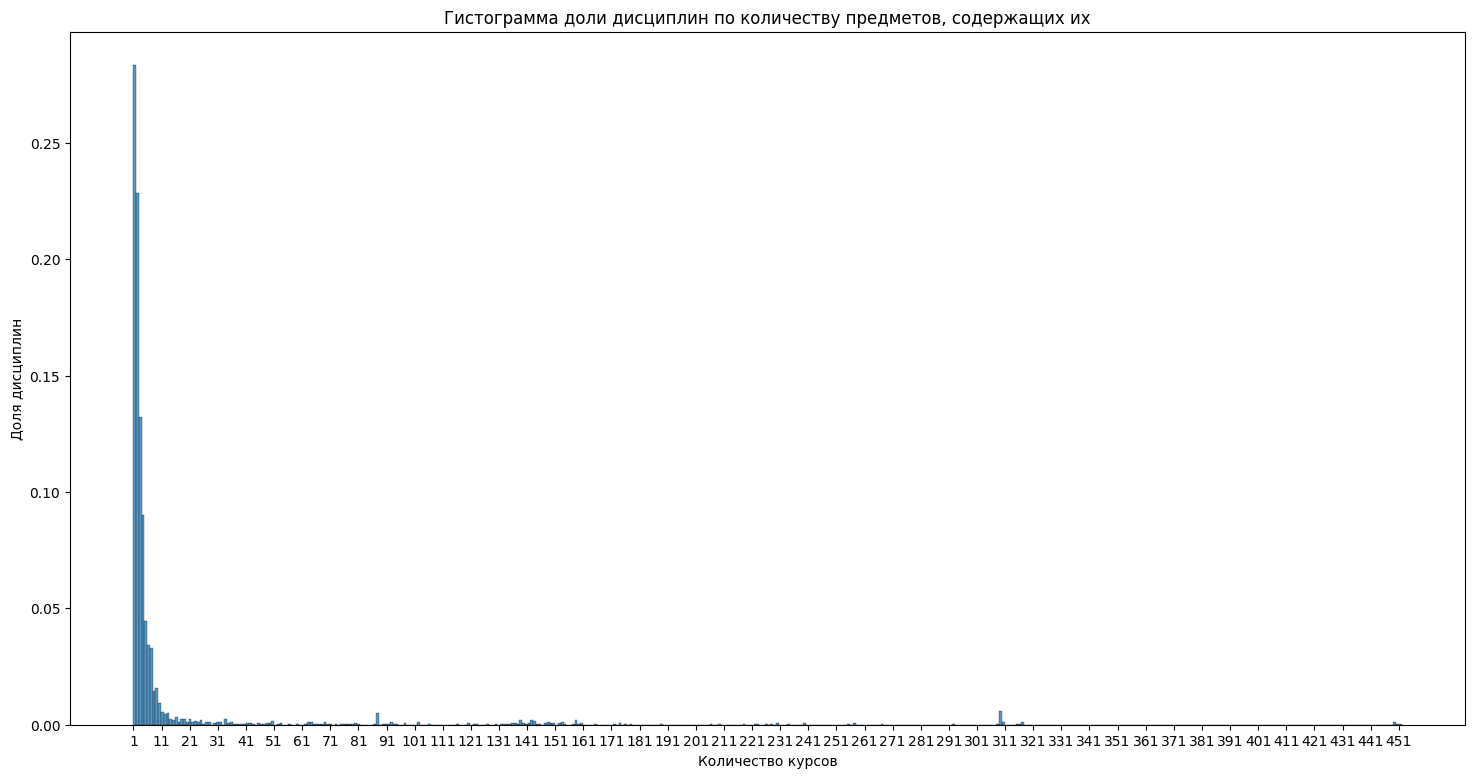

In [ ]:
plt.figure(figsize=(18, 9))
ax = sns.histplot(course_plans_df.up_id, bins=num_bins, stat="probability")
ax.set_xticks(x_ticks)
plt.title("Гистограмма доли дисциплин по количеству предметов, содержащих их")
plt.xlabel("Количество курсов")
plt.ylabel("Доля дисциплин")
plt.show()

**Определим порог, чтобы считать дисциплину общей**

Попробуем оставить 90% дисциплин.

In [ ]:
course_plans_filtered_df = course_plans_df.query("up_id < 14")
course_plans_filtered_df.shape[0] / course_plans_df.shape[0]

0.9016382344976983

In [ ]:
course_plans_filtered_df.sample(3)

,,up_id
course_title,full_description,
Компьютерная лингвистика,курс рассмотреть основной понятие системный анализ теория принятие решение уровень решение задача условие неопределенность представить пример математический моделирование система процесс также пример решение практический задача векторный представление текст обработка текст,3
Экологический дизайн / Environmental Design,environmental design is a discipline that is an extension of the discipline of life cycle assessment helps to understand and study the concept of life cycle assessment and environmental design for environmental management purposes much deeper goals and tasks of lca and possibilities of lca software overview of simapro,2
Основы химии,курс основа химия являться базовый курс химия студент курс университет итмо курс кратко излагаться основополагающий вопрос общий химия связать строение атом вещество теория химический связь термохимия химический кинетика химия раствор электрохимия периодический система менделеев современный трактовка периодический закон энергия ионизация энергия сродство электрон понятие электроотрицательность эо шкала эо малликен оллред рохов полингу квантовый химия,9


In [ ]:
discipline_data_filtered = discipline_data[
    discipline_data.course_title.isin(course_plans_filtered_df.index.get_level_values(0)) &
    discipline_data.full_description.isin(course_plans_filtered_df.index.get_level_values(1))
]
display(discipline_data_filtered.shape)
display(discipline_data_filtered.sample(3))

(239163, 11)

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,full_description,tokenized_description,description_embedding
7031,11278,Технологии машинного обучения / Machine Learning,master,29,7016,Большие данные и машинное обучение,2020,Профильный профессиональный модуль,students will gain an understanding of the bas...,"['students', 'will', 'gain', 'an', 'understand...","[-1.0110920667648315, -1.7386404275894165, -0...."
67717,4913,Аддитивные технологии и быстрое производство,master,2,7160,Индустриальные киберфизические системы,2021,"Специализация ""Технологическая подготовка прои...",ход изучение дисциплина изучить существовать т...,"['ход', 'изучение', 'дисциплина', 'изучить', '...","[2.303865432739258, 0.5209174156188965, -1.084..."
626556,13591,Комплексное развитие урбанизированных территорий,master,30,7111,Умный город и урбанистика,2021,Факультативные дисциплины,изучаться основа градостроительный планировани...,"['изучаться', 'основа', 'градостроительный', '...","[0.8732131719589233, 0.4362685978412628, 0.431..."


**Сохраним датафрейм**

In [ ]:
discipline_data_filtered.to_csv("D:/Data/discipline_data_step_5.csv", sep=";", index=False, encoding="utf-8")

**Повторим эксперимент**

**Построим векторные представления учебных планов**

In [ ]:
study_plans_filtered_df = discipline_data_filtered.groupby("up_id").description_embedding.agg(list_mean).reset_index()

In [ ]:
study_plans_filtered_df.shape[0]

514

In [ ]:
study_plans_filtered_df.rename(columns={"description_embedding": "up_embedding"}, inplace=True)
study_plans_filtered_df.sample(3)

,up_id,up_embedding
60,6926,"[1.4866614784103644, -0.0780629185182032, 0.12..."
355,7246,"[1.5849118435799459, 0.20368150953080366, -0.2..."
321,7212,"[0.7809273359663508, 0.0448369150981307, 0.235..."


**Сохраним датафрейм**

In [ ]:
study_plans_filtered_df.to_csv("D:/Data/study_plans_filtered.csv", sep=";", index=False, encoding="utf-8")

**Напишем метод для получения ранжированных дисциплин по id плана**

In [ ]:
def get_filtered_disciplines_distances_by_up_id(up_id: int) -> pd.DataFrame:
    plan_embedding = study_plans_filtered_df[study_plans_filtered_df.up_id == up_id].up_embedding.iloc[0]
    corresponding_disciplines = discipline_data_filtered[discipline_data_filtered.up_id == up_id]
    corresponding_disciplines["cosine_similarity"] = corresponding_disciplines.description_embedding.apply(get_cosine_similarity, args=(plan_embedding,))
    return corresponding_disciplines[["course_title", "cosine_similarity"]].sort_values(by="cosine_similarity", ascending=False)

**Протестируем метод на выбранных планах**

*7289 - Робототехника и искусственный интеллект*

In [ ]:
plan_7289_filtered_df = get_filtered_disciplines_distances_by_up_id(7289)
display(plan_7289_filtered_df.shape)
print(f"Среднее сходство: {plan_7289_filtered_df.cosine_similarity.mean()}")

(1761, 2)

Среднее сходство: 0.6717415202794275


**Количество дисциплин 3602 -> 1761; Среднее сходство 0.56 -> 0.67**

In [ ]:
plan_7289_filtered_df.cosine_similarity.min()

0.3971687700521193

In [ ]:
display(plan_7289_filtered_df[plan_7289_filtered_df.cosine_similarity.between(0.35, 0.55)].sample(10))

,course_title,cosine_similarity
763588,Программирование микроконтроллеров,0.492998
754559,Теория функции комплексного переменного,0.397169
760387,Электричество и магнетизм,0.540086
763524,Программирование микроконтроллеров,0.516075
763399,Программирование микроконтроллеров,0.495595
754601,Теория функции комплексного переменного,0.478693
754614,Теория функции комплексного переменного,0.465696
763650,Программирование микроконтроллеров,0.470797
763546,Программирование микроконтроллеров,0.476024
754530,Теория функции комплексного переменного,0.463624


**Умозрительно кажется, что все дисциплины релевантны к курсу**

Проверим, сколько лишних дисциплин.

In [ ]:
0

0

*7452 - Химия и искусственный интеллект / Chemistry and Artificial Intelligence*

In [ ]:
plan_7452_filtered_df = get_filtered_disciplines_distances_by_up_id(7452)
display(plan_7452_filtered_df.shape)
print(f"Среднее сходство: {plan_7452_filtered_df.cosine_similarity.mean()}")

(58, 2)

Среднее сходство: 0.9846440316420225


**Количество дисциплин 125 -> 58; Среднее сходство 0.99 -> 0.98**

In [ ]:
display(plan_7452_filtered_df.sample(10))

,course_title,cosine_similarity
585561,Молекулярная нейронаука / Molecular Neuroscience,0.997316
585646,Молекулярная нейронаука / Molecular Neuroscience,0.997396
585408,Молекулярная нейронаука / Molecular Neuroscience,0.997878
585731,Молекулярная нейронаука / Molecular Neuroscience,0.997518
585816,Молекулярная нейронаука / Molecular Neuroscience,0.996534
585323,Молекулярная нейронаука / Molecular Neuroscience,0.997324
834921,Иностранный язык в профессиональной деятельнос...,0.929383
585782,Молекулярная нейронаука / Molecular Neuroscience,0.997039
585680,Молекулярная нейронаука / Molecular Neuroscience,0.997215
585510,Молекулярная нейронаука / Molecular Neuroscience,0.997345


**Умозрительно величина 0.93 кажется подходящим порогом**

Проверим, сколько лишних дисциплин.

In [ ]:
display(plan_7452_filtered_df.query("cosine_similarity < 0.93").shape[0])

5

*7630 - Робототехника и искусственный интеллект / Robotics and artificial intelligence*

In [ ]:
plan_7630_filtered_df = get_filtered_disciplines_distances_by_up_id(7630)
display(plan_7630_filtered_df.shape)
print(f"Среднее сходство: {plan_7630_filtered_df.cosine_similarity.mean()}")

(16, 2)

Среднее сходство: 0.5253021369428412


**Количество дисциплин 16 -> 16; Среднее сходство 0.53 -> 0.53**

In [ ]:
display(plan_7630_filtered_df.sample(16))

,course_title,cosine_similarity
742202,Проектирование биомехатронных систем / Biomech...,0.670123
742222,Проектирование биомехатронных систем,0.378878
742192,Проектирование биомехатронных систем / Biomech...,0.667004
742198,Проектирование биомехатронных систем / Biomech...,0.670697
742220,Проектирование биомехатронных систем,0.384105
742216,Проектирование биомехатронных систем,0.383192
742200,Проектирование биомехатронных систем / Biomech...,0.668085
742218,Проектирование биомехатронных систем,0.378536
742196,Проектирование биомехатронных систем / Biomech...,0.669508
742212,Проектирование биомехатронных систем,0.387443


**Умозрительно кажется, что все дисциплины релевантны к курсу**

Проверим, сколько лишних дисциплин.

In [ ]:
0

0

*7109 - Программирование и искусственный интеллект*

In [ ]:
plan_7109_filtered_df = get_filtered_disciplines_distances_by_up_id(7109)
display(plan_7109_filtered_df.shape)
print(f"Среднее сходство: {plan_7109_filtered_df.cosine_similarity.mean()}")

(110, 2)

Среднее сходство: 0.706964055557551


**Количество дисциплин 1479 -> 110; Среднее сходство 0.43 -> 0.71**

In [ ]:
plan_7109_filtered_df.cosine_similarity.min()

0.40816286035255905

In [ ]:
display(plan_7109_filtered_df[plan_7109_filtered_df.cosine_similarity.between(0.4, 0.5)])

,course_title,cosine_similarity
612296,Управление проектами в информационных технологиях,0.486846
611773,Верификация программного обеспечения,0.456725
612292,Управление проектами в информационных технологиях,0.455112
612300,Управление проектами в информационных технологиях,0.447730
612294,Управление проектами в информационных технологиях,0.440435
611771,Верификация программного обеспечения,0.432589
612290,Управление проектами в информационных технологиях,0.408163


**Умозрительно кажется, что все дисциплины релевантны к курсу**

Проверим, сколько лишних дисциплин.

In [ ]:
0

0

*7016 - Большие данные и машинное обучение*

In [ ]:
plan_7016_filtered_df = get_filtered_disciplines_distances_by_up_id(7016)
display(plan_7016_filtered_df.shape)
print(f"Среднее сходство: {plan_7016_filtered_df.cosine_similarity.mean()}")

(355, 2)

Среднее сходство: 0.9194281405926782


**Количество дисциплин 1732 -> 355; Среднее сходство 0.41 -> 0.92**

In [ ]:
plan_7016_filtered_df.cosine_similarity.min()

-0.10991104373811131

In [ ]:
display(plan_7016_filtered_df[plan_7016_filtered_df.cosine_similarity.between(-0.2, 0.5)].sample(10))

,course_title,cosine_similarity
160467,Основы финансовой грамотности,-0.057163
159489,Основы финансовой грамотности,-0.087046
162260,Основы финансовой грамотности,-0.069823
162097,Основы финансовой грамотности,-0.072371
160141,Основы финансовой грамотности,-0.103730
160304,Основы финансовой грамотности,-0.068047
161934,Основы финансовой грамотности,-0.085201
159326,Основы финансовой грамотности,-0.071579
161282,Основы финансовой грамотности,-0.092833
159978,Основы финансовой грамотности,-0.076203


In [ ]:
display(plan_7016_filtered_df[plan_7016_filtered_df.cosine_similarity.between(0, 1)].sample(10))

,course_title,cosine_similarity
147815,Непрерывные математические модели / Continuous...,0.975813
6771,Инфраструктура больших данных / Technologies a...,0.970278
407561,Машинное обучение и искусственный интеллект / ...,0.958916
6543,Методология трансляционных исследований / Meth...,0.974297
13768,Дискретные математические модели / Discrete mo...,0.975375
6847,Анализ и разработка алгоритмов / Analysis and ...,0.986254
6835,Анализ и разработка алгоритмов / Analysis and ...,0.986078
7036,Технологии машинного обучения / Machine Learning,0.969641
19136,Специализированные технологии больших данных /...,0.980803
13899,Непрерывные математические модели / Continuous...,0.975813


Умозрительно величина 0 кажется подходящим порогом

Проверим, сколько лишних дисциплин.

In [ ]:
display(plan_7016_filtered_df.query("cosine_similarity < 0").shape[0])

18

## Вывод по этапу 5
Можно заметить, что количество лишних дисциплин, как и их доля упали. Курсы стали выглядеть гораздо более релевантно.

Можно сказать, что наш подход был успешен.

## Этап 6 - Генерация собственного описания дисциплины с помощью Llama2

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

**Сформируем датасет для дообучения**

In [ ]:
discipline_data_full_description = pd.read_csv("D:/Data/discipline_data_step_1.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_data_full_description.sample(3)

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,full_description
960806,22681,Экспериментальные методы клеточной биологии,All_levels,40,7123,Компьютерные технологии в дизайне,2021,Общеуниверситетские факультативы,Данный курс покажет вам одновременно высокую т...
449217,15932,Россия в мировых войнах,All_levels,1,6877,Экономика высокотехнологичной компании,2018,Факультативные дисциплины,Современное общество требует от гражданина глу...
967700,24176,Иностранный язык в профессиональной деятельности,bachelor,9,6957,Технологии защиты информации,2021,Иностранный язык (6 сем),Целью освоения дисциплины является достижение ...


In [ ]:
discipline_data_train = pd.DataFrame()
HUMAN_PROMPT = "Сгенерируй описание для учебного курса с названием"
discipline_data_train["prompt"] = discipline_data_full_description.course_title.apply(lambda s: f"{HUMAN_PROMPT} `{s}`")

In [ ]:
discipline_data_train["description"] = discipline_data_full_description.full_description

In [ ]:
discipline_data_train.sample(3)

,prompt,description
302972,Сгенерируй описание для учебного курса с назва...,Дисциплина позволит студенту получить знания в...
694635,Сгенерируй описание для учебного курса с назва...,Sonochemistry or Sonochemistry is a branch of ...
915311,Сгенерируй описание для учебного курса с назва...,Иностранные языки необходимы современному чело...


In [ ]:
discipline_data_train = pd.DataFrame()
discipline_data_train["input"] = discipline_data_full_description.course_title
discipline_data_train["instruction"] = HUMAN_PROMPT
discipline_data_train["output"] = discipline_data_full_description.full_description
discipline_data_train.drop_duplicates(inplace=True)
discipline_data_train = discipline_data_train[["instruction", "input", "output"]]

In [ ]:
discipline_data_train.sample(3)

,instruction,input,output
509774,Сгенерируй описание для учебного курса с назва...,Линейная алгебра (продвинутый раздел),В результате освоения курса студенты получат п...
407554,Сгенерируй описание для учебного курса с назва...,Физика конденсированных сред,Дисциплина содержит сведения о строении тверды...
760248,Сгенерируй описание для учебного курса с назва...,Вакуумные техника и технологии,Программа предназначена для работы студентов ...


In [ ]:
def format_llama_prompt(series: pd.Series) -> str:
    return f"<s>[INST] {series['prompt']} [/INST] {series['description']} </s>"

discipline_data_train["text"] = discipline_data_train.apply(format_llama_prompt, axis=1)

In [ ]:
discipline_data_train.sample(3)

,prompt,description,text
30764,Сгенерируй описание для учебного курса с назва...,В ходе изучения дисциплины рассматриваются сис...,<s>[INST] Сгенерируй описание для учебного кур...
496419,Сгенерируй описание для учебного курса с назва...,"Основной круг вопросов, рассматриваемых при ос...",<s>[INST] Сгенерируй описание для учебного кур...
902652,Сгенерируй описание для учебного курса с назва...,"Основа современного общественного устройства, ...",<s>[INST] Сгенерируй описание для учебного кур...


In [ ]:
discipline_data_train[["text"]].to_csv("D:/Data/train_full.csv", index=False, encoding="utf-8")

In [ ]:
discipline_data_train = pd.read_csv("D:/Data/train_full.csv", encoding="utf-8")

In [ ]:
discipline_data_train.drop_duplicates(inplace=True)

In [ ]:
discipline_data_train.to_csv("D:/Data/train.csv", index=False, encoding="utf-8")

**Загрузим его на HuggingFaces**

**Укажем версии моделей и датасетов**

In [ ]:
base_model = "NousResearch/Llama-2-7b-chat-hf"
my_dataset = "wilfordaf/itmo-ml-lab3-train"
new_model = "llama-2-7b-chat-wilfordaf"

**Загрузим датасет**

In [ ]:
dataset = load_dataset(my_dataset, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 77056
})

**4-bit quantization конфигурация**

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)

**Загрузим модель**

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Загрузим токенайзер**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

**Параметры PEFT**

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

**Параметры обучения**

In [ ]:
training_params = TrainingArguments(
    output_dir="../results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant"
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_params,
)

Map:   0%|          | 0/77056 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

MissingConfigError: It seems ClearML is not configured on this machine!
To get started with ClearML, setup your own 'clearml-server' or create a free account at https://app.clear.ml
Setup instructions can be found here: https://clear.ml/docs

In [ ]:
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)

In [ ]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Who is Leonardo Da Vinci?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

**К сожалению, дообучение по данному пайплайну не работает как локально, так и в colab**

Попробуем приложение https://github.com/oobabooga/text-generation-webui

Будем использовать модель *meta-llama/Llama-2-7b-chat-hf*

**Подготовим выборку для этого приложения**

Для моделей Llama, формат следующий:

- .json файл
- поля systemprompt; userprompt; modelanswer

In [ ]:
discipline_data_train.to_json("../data/train.json", orient="records", force_ascii=False, indent=4)

**На выборке из 77_000 образцов создание LORA займёт 18 часов**

![photo_2024-03-08_22-17-30.jpg](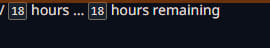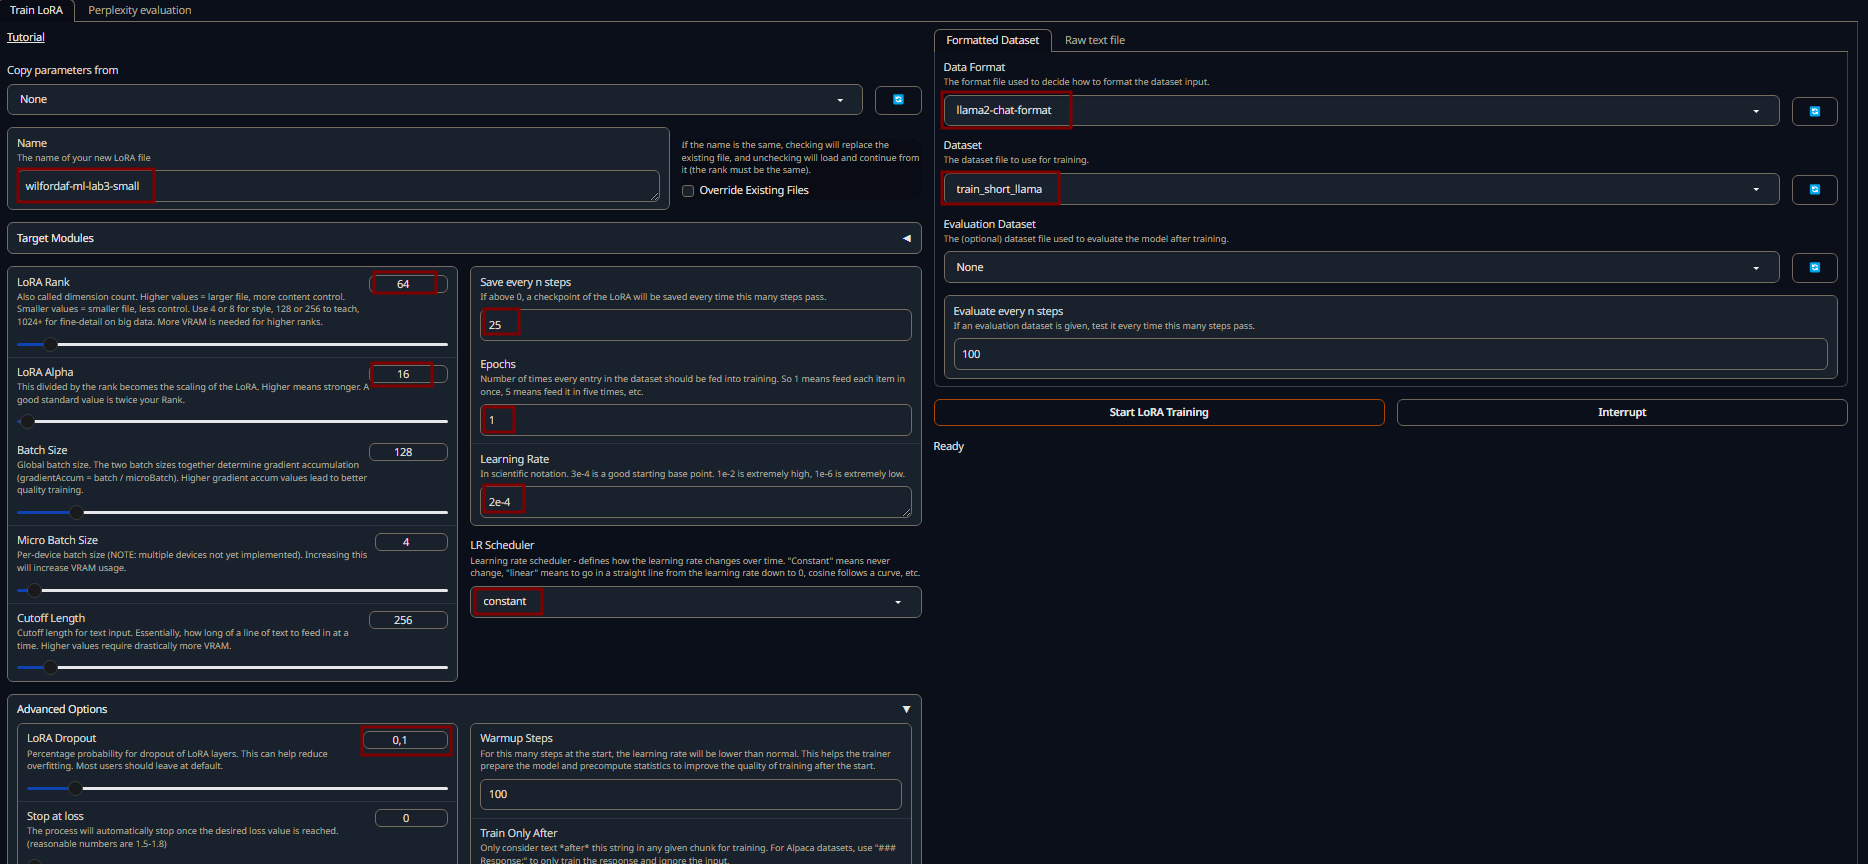)

**Ужмём выборку до 2_000**

In [ ]:
with open("../data/train.json", encoding="utf-8") as fin:
    content = json.load(fin)

content = content[:8000]

In [ ]:
with open("../data/train_short.json", "w", encoding="utf-8") as fout:
    json.dump(content, fout, indent=4, ensure_ascii=False)

**Теперь время обучения составляет 2 часа, что приемлемо**

**Настройки для обучения**



**Давайте протестируем модель**

Настройки:

<img src="../reports/screenshots/2024-03-09_01-17.png">


**Из тренировочной выборки**

<img src="../reports/screenshots/2024-03-09_00-52.png">

**Из тестовой выборки**

<img src="../reports/screenshots/2024-03-09_01-03.png">

Все тестовые кейсы, которые я провёл:

**TRAIN**

Сгенерируй описание для учебного курса с названием `Архитектура информационных систем`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные принципы проектирования и разработки информационных систем, а также методы их анализа и оптимизации. В ходе изучения дисциплины студенты получают знания в области: 1) теории информационной безопасности; 2) баз данных; 3) базовых алгоритмов машинного обучения; 4) веб-разработки; 5) серверных технологий; 6) сетевых протоколов; 7) моделирования сложных систем; 8) управления качеством; 9) управления рисками; 10) управления проектами.


Сгенерируй описание для учебного курса с названием `Квантовые когнитивные технологии систем искусственного интеллекта`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные принципы квантовых алгоритмов и их применения в системах искусственного интеллекта. В ходе изучения курса студенты получают знания о том, как квантовые процессоры могут использоваться для решения задач машинного обучения, обработки естественного языка, а также для создания новых квантовых алгоритмов.


Сгенерируй описание для учебного курса с названием `Методы оптимизации и оптимальное управление`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные методы оптимизации, используемые в различных областях науки и техники. В ходе изучения курса студенты получают знания о принципах оптимизации, а также о том, как они могут быть использованы для решения различных задач. Курс содержит информацию о таких методах, как:

Сгенерируй описание для учебного курса с названием `История (Проблемы истории Европы ХХ века)`.

Ответ должен быть на русском языке.

В рамках дисциплины рассмотрены проблемы, связанные с историческими процессами в Европе XX веке. В ходе изучения студенты узнают о причинах и последствиях II мировой войны, о роли СССР в этом конфликте, о послевоенном размежевании стран, о развитии идеи демократического социализма в странах Запада, о роли США в международных отношениях в 1945-1990-е годы.


Сгенерируй описание для учебного курса с названием `Разработка и прототипирование световых решений в городской среде / Development of Lighting Solutions in Urban Environment`.

Ответ должен быть на русском языке.

В рамках дисциплины студенты изучают основные принципы проектирования и разработки светотехнических систем, используемых в современных городах. В ходе выполнения задач студенты получают представление о том, как создавать эффективные и экологичные световые решения в различных типах объектов, таких как: общественные пространства, здания, транспортные средства, производственные предприятия. Работа над проектом включает в себя также исследование и анализ технологических и энергетических параметров светотехнических устройств, а также их влияния на окружающую среду.

**TEST**

Сгенерируй описание для учебного курса с названием `Современные оптические телескопы`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные принципы современных оптических телескопов, их конструкция и применение в различных областях науки и техники. В ходе изучения курса студенты знакомятся с основными принципами работы оптических телескопов, их конструкцией и применением в различных областях науки и техники.


Сгенерируй описание для учебного курса с названием `Основы теории цепей`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные принципы теории цепей, а также методы анализа и синтеза электронных цепей. В ходе изучения дисциплины студенты получают знания в области:

* теории электроники;
* теории цепей;
* методов анализа и синтеза электронных цепей;
* принципов проектирования электронных цепей;


Сгенерируй описание для учебного курса с названием `Физика наноструктур`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные физические свойства и принципы работы наноструктур, а также методы их исследования. В ходе изучения дисциплины студенты получают знания в области:

1. Физики наноструктур;
2. Квантовых явлений в наноструктурах;
3. Электрофизических явлений в наноструктурах;
4. Оптических явлений в наноструктурах;
5. Механических явлений в наноструктурах.

Курс содержит информацию о том, как наноструктуры могут использоваться для решения различных задач, связанных с оптическими, электронными и квантовыми явлениями.


Сгенерируй описание для учебного курса с названием `Системы и архитектуры резервного копирования и восстановления`.

Ответ должен быть на русском языке.

В данном курсе рассматриваются основные принципы и методы создания резервных копий данных, а также методы их хранения и восстановления. В ходе изучения дисциплины студенты получают знания о современных технологиях резервного копирования данных, их особенностях и преимуществах.


Сгенерируй описание для учебного курса с названием `Основы разработки веб-интерфейсов`.

Ответ должен быть на русском языке.

В данном курсе рассмотрены основные принципы создания веб-приложений, а также технологии и инструменты для их разработки. В ходе изучения курса студенты получают знания в области:

* Технологии веб-разработки (HTML, CSS, JavaScript);
* Протоколы передачи данных (HTTP, HTTPS);
* Обеспечение безопасности веб-приложений;
* Разработка веб-приложений с использованием современных технологий (RESTful API, GraphQL).

Курс содержит практические задания, которые помогают студентам приобрести опыт работы с веб-технологиями.

**Давайте посмотрим, как ведёт себя модель без дообучения**

<img src="/reports/screenshots/2024-03-09_09-58.png">

**Ещё пример**

<img src="../reports/screenshots/2024-03-09_10-00.png">

## Вывод по этапу 6

Удалось провести дообучение и протестировать модель.

С созданной LORA модель действительно более точно отвечает на поставленные запросы.

Созданные описания выглядят адекватно, хотя могут не отражать реального положения дел.

## Этап 7 - Созданные описания vs Реальные

In [ ]:
from ml_data_engine import DataProcessor, YAMLConfigParser

In [ ]:
word2vec_model = Word2Vec.load("../models/word2vec_07032024.model")
dp = DataProcessor(YAMLConfigParser("../configs/preprocessing.yaml"))

In [ ]:
discipline_data = pd.read_csv("D:/Data/discipline_data_step_4.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_data.sample(3)

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,full_description,tokenized_description,description_embedding
586149,17785,Нанотоксикология / Nanotoxicology,master,28,7181,Прикладная геномика / Applied genomics,2022,Трек 1 (дисциплины + майнор),students will know how to formulate the basic ...,"['students', 'will', 'know', 'how', 'to', 'for...","[-0.7552087306976318, -1.6715145111083984, 0.3..."
958456,22681,Экспериментальные методы клеточной биологии,All_levels,40,7270,Цифровая урбанистика,2022,Общеуниверситетские факультативы,данный курс показать одновременно высокий техн...,"['данный', 'курс', 'показать', 'одновременно',...","[0.3843121826648712, -0.013897531665861607, -0..."
370764,16422,Экология,bachelor,6,6912,Прикладная и теоретическая физика,2020,Модуль обязательных дисциплин,содержание дисциплина охватывать круг вопрос с...,"['содержание', 'дисциплина', 'охватывать', 'кр...","[-0.6148910522460938, -0.45974984765052795, 0...."


In [ ]:
discipline_data = discipline_data[["course_title", "start_year", "description_embedding"]]
discipline_data.drop_duplicates(inplace=True)
discipline_data.shape

(144380, 3)

**Будем оценивать сразу по годам, т.к. почти все протестированные дисциплины имеют такую возможность**

Создадим методы.

In [ ]:
def list_mean(series: pd.Series) -> List[float]:
    return np.mean([json.loads(item) for item in series.values], axis=0)

def get_embeddings_cosine_similarity(embedding: str, embedding_other: str) -> float:
    return cosine_similarity([embedding], [embedding_other])[0][0]

def get_course_years_df(course_title: str) -> pd.DataFrame:
    different_years = discipline_data[discipline_data.course_title == course_title]
    return different_years.groupby("start_year").description_embedding.agg(list_mean).reset_index().sort_values(by="start_year")

def print_course_years_stats(course_years: pd.DataFrame) -> None:
    if course_years.shape[0] < 2:
        print(f"Количество сущностей {course_years.shape[0]}")
        return

    cosine_similarities = []
    for i, row in course_years.iterrows():
        for j, row_other in course_years.iterrows():
            if i <= j:
                continue

            cosine_similarities.append(
                get_embeddings_cosine_similarity(row["description_embedding"], row_other["description_embedding"])
            )

    print(f"Среднее сходство: {np.mean(cosine_similarities)}\n"
          f"Максимальное сходство {max(cosine_similarities)}\n"
          f"Минимальное сходство {min(cosine_similarities)}\n"
          f"Количество сущностей {course_years.shape[0]}")

def vectorize(sentence: List[str], word2vec_model: Word2Vec) -> List[float]:
    if not sentence:
        return np.zeros(word2vec_model.vector_size).tolist()

    if not (vectors := [word2vec_model.wv[token] for token in sentence if token in word2vec_model.wv]):
        return np.zeros(word2vec_model.vector_size).tolist()

    return np.mean(vectors, axis=0).tolist()

def get_closest_year(description: str, course_years: pd.DataFrame) -> int:
    preprocessed_description = dp.process_single_text(description)
    tokenized_description = word_tokenize(description)
    description_embedding = vectorize(tokenized_description, word2vec_model)
    cosine_similarities = []
    for _, row in course_years.iterrows():
        cosine_similarities.append(
                get_embeddings_cosine_similarity(row["description_embedding"], description_embedding)
            )

    print(f"Среднее сходство: {np.mean(cosine_similarities)}\n"
          f"Максимальное сходство {max(cosine_similarities)}\n"
          f"Минимальное сходство {min(cosine_similarities)}")

    max_index = np.argmax(cosine_similarities)
    print(course_years.iloc[max_index].start_year)

*Архитектура информационных систем*

In [ ]:
NAME = "Архитектура информационных систем"
DESCRIPTION = "В данном курсе рассматриваются основные принципы проектирования и разработки информационных систем, а также методы их анализа и оптимизации. В ходе изучения дисциплины студенты получают знания в области: 1) теории информационной безопасности; 2) баз данных; 3) базовых алгоритмов машинного обучения; 4) веб-разработки; 5) серверных технологий; 6) сетевых протоколов; 7) моделирования сложных систем; 8) управления качеством; 9) управления рисками; 10) управления проектами."

In [ ]:
ais_df = get_course_years_df(NAME)
print_course_years_stats(ais_df)

Среднее сходство: 0.9911411215496543
Максимальное сходство 1.0000000000000007
Минимальное сходство 0.9778528038741351
Количество сущностей 5


In [ ]:
get_closest_year(DESCRIPTION, ais_df)

Среднее сходство: 0.379709531628553
Максимальное сходство 0.37992663733759524
Минимальное сходство 0.3796552552012924
2018


*Квантовые когнитивные технологии систем искусственного интеллекта / Quantum Cognitive Technologies of AI Systems*

In [ ]:
NAME = "Квантовые когнитивные технологии систем искусственного интеллекта / Quantum Cognitive Technologies of AI Systems"
DESCRIPTION = "В данном курсе рассматриваются основные принципы квантовых алгоритмов и их применения в системах искусственного интеллекта. В ходе изучения курса студенты получают знания о том, как квантовые процессоры могут использоваться для решения задач машинного обучения, обработки естественного языка, а также для создания новых квантовых алгоритмов."

In [ ]:
quant_ml_df = get_course_years_df(NAME)
print_course_years_stats(quant_ml_df)

Среднее сходство: 1.0
Максимальное сходство 1.0
Минимальное сходство 1.0
Количество сущностей 3


In [ ]:
get_closest_year(DESCRIPTION, quant_ml_df)

Среднее сходство: -0.14002211789930524
Максимальное сходство -0.14002211789930524
Минимальное сходство -0.14002211789930524
2020


*Методы оптимизации и оптимальное управление / Optimization Method and Optimal Control*

In [ ]:
NAME = "Методы оптимизации и оптимальное управление / Optimization Method and Optimal Control"
DESCRIPTION = "В данном курсе рассматриваются основные методы оптимизации, используемые в различных областях науки и техники. В ходе изучения курса студенты получают знания о принципах оптимизации, а также о том, как они могут быть использованы для решения различных задач. Курс содержит информацию о таких методах, как:"

In [ ]:
optimization_df = get_course_years_df(NAME)
print_course_years_stats(optimization_df)

Среднее сходство: 1.0000000000000002
Максимальное сходство 1.0000000000000002
Минимальное сходство 1.0000000000000002
Количество сущностей 2


In [ ]:
get_closest_year(DESCRIPTION, optimization_df)

Среднее сходство: 0.18788970889108608
Максимальное сходство 0.18788970889108608
Минимальное сходство 0.18788970889108608
2020


*История (Проблемы истории Европы ХХ века)*

In [ ]:
NAME = "История (Проблемы истории Европы ХХ века)"
DESCRIPTION = "В рамках дисциплины рассмотрены проблемы, связанные с историческими процессами в Европе XX веке. В ходе изучения студенты узнают о причинах и последствиях II мировой войны, о роли СССР в этом конфликте, о послевоенном размежевании стран, о развитии идеи демократического социализма в странах Запада, о роли США в международных отношениях в 1945-1990-е годы."

In [ ]:
history_df = get_course_years_df(NAME)
print_course_years_stats(history_df)

Среднее сходство: 1.0000000000000002
Максимальное сходство 1.0000000000000002
Минимальное сходство 1.0000000000000002
Количество сущностей 3


In [ ]:
get_closest_year(DESCRIPTION, history_df)

Среднее сходство: 0.3042877637925562
Максимальное сходство 0.3042877637925562
Минимальное сходство 0.3042877637925562
2019


*Разработка и прототипирование световых решений в городской среде / Development of Lighting Solutions in Urban Environment*

In [ ]:
NAME = "Разработка и прототипирование световых решений в городской среде / Development of Lighting Solutions in Urban Environment"
DESCRIPTION = "В рамках дисциплины студенты изучают основные принципы проектирования и разработки светотехнических систем, используемых в современных городах. В ходе выполнения задач студенты получают представление о том, как создавать эффективные и экологичные световые решения в различных типах объектов, таких как: общественные пространства, здания, транспортные средства, производственные предприятия. Работа над проектом включает в себя также исследование и анализ технологических и энергетических параметров светотехнических устройств, а также их влияния на окружающую среду."

In [ ]:
light_df = get_course_years_df(NAME)
print_course_years_stats(light_df)

Среднее сходство: 1.0000000000000004
Максимальное сходство 1.0000000000000004
Минимальное сходство 1.0000000000000004
Количество сущностей 2


In [ ]:
get_closest_year(DESCRIPTION, light_df)

Среднее сходство: -0.22720184757676284
Максимальное сходство -0.22720184757676284
Минимальное сходство -0.22720184757676284
2020


*Современные оптические телескопы*

In [ ]:
NAME = "Современные оптические телескопы"
DESCRIPTION = "В данном курсе рассматриваются основные принципы современных оптических телескопов, их конструкция и применение в различных областях науки и техники. В ходе изучения курса студенты знакомятся с основными принципами работы оптических телескопов, их конструкцией и применением в различных областях науки и техники."

In [ ]:
telescope_df = get_course_years_df(NAME)
print_course_years_stats(telescope_df)

Среднее сходство: 1.0000000000000009
Максимальное сходство 1.0000000000000009
Минимальное сходство 1.0000000000000009
Количество сущностей 2


In [ ]:
get_closest_year(DESCRIPTION, telescope_df)

Среднее сходство: 0.41542854947334096
Максимальное сходство 0.41542854947334096
Минимальное сходство 0.41542854947334096
2020


*Основы теории цепей*

In [ ]:
NAME = "Основы теории цепей"
DESCRIPTION = """В данном курсе рассматриваются основные принципы теории цепей, а также методы анализа и синтеза электронных цепей. В ходе изучения дисциплины студенты получают знания в области:

* теории электроники;
* теории цепей;
* методов анализа и синтеза электронных цепей;
* принципов проектирования электронных цепей;"""

In [ ]:
chain_df = get_course_years_df(NAME)
print_course_years_stats(chain_df)

Количество сущностей 1


In [ ]:
get_closest_year(DESCRIPTION, chain_df)

Среднее сходство: 0.21067023398617657
Максимальное сходство 0.21067023398617657
Минимальное сходство 0.21067023398617657
2022


*Физика наноструктур / Physics of Nanostructures*

In [ ]:
NAME = "Физика наноструктур / Physics of Nanostructures"
DESCRIPTION = """В данном курсе рассматриваются основные физические свойства и принципы работы наноструктур, а также методы их исследования. В ходе изучения дисциплины студенты получают знания в области:

1. Физики наноструктур;
2. Квантовых явлений в наноструктурах;
3. Электрофизических явлений в наноструктурах;
4. Оптических явлений в наноструктурах;
5. Механических явлений в наноструктурах.

Курс содержит информацию о том, как наноструктуры могут использоваться для решения различных задач, связанных с оптическими, электронными и квантовыми явлениями."""

In [ ]:
nano_df = get_course_years_df(NAME)
print_course_years_stats(nano_df)

Количество сущностей 1


In [ ]:
get_closest_year(DESCRIPTION, nano_df)

Среднее сходство: -0.10579840780046303
Максимальное сходство -0.10579840780046303
Минимальное сходство -0.10579840780046303
2022


*Системы и архитектуры резервного копирования и восстановления*

In [ ]:
NAME = "Системы и архитектуры резервного копирования и восстановления"
DESCRIPTION = "В данном курсе рассматриваются основные принципы и методы создания резервных копий данных, а также методы их хранения и восстановления. В ходе изучения дисциплины студенты получают знания о современных технологиях резервного копирования данных, их особенностях и преимуществах."

In [ ]:
copy_df = get_course_years_df(NAME)
print_course_years_stats(copy_df)

Среднее сходство: 1.0000000000000002
Максимальное сходство 1.0000000000000002
Минимальное сходство 1.0000000000000002
Количество сущностей 4


In [ ]:
get_closest_year(DESCRIPTION, copy_df)

Среднее сходство: 0.21884573287392162
Максимальное сходство 0.21884573287392162
Минимальное сходство 0.21884573287392162
2019


In [ ]:
NAME = "Основы разработки веб-интерфейсов"
DESCRIPTION = """В данном курсе рассмотрены основные принципы создания веб-приложений, а также технологии и инструменты для их разработки. В ходе изучения курса студенты получают знания в области:

* Технологии веб-разработки (HTML, CSS, JavaScript);
* Протоколы передачи данных (HTTP, HTTPS);
* Обеспечение безопасности веб-приложений;
* Разработка веб-приложений с использованием современных технологий (RESTful API, GraphQL).

Курс содержит практические задания, которые помогают студентам приобрести опыт работы с веб-технологиями."""

In [ ]:
web_df = get_course_years_df(NAME)
print_course_years_stats(web_df)

Количество сущностей 1


In [ ]:
get_closest_year(DESCRIPTION, web_df)

Среднее сходство: 0.2074642849816803
Максимальное сходство 0.2074642849816803
Минимальное сходство 0.2074642849816803
2021


## Вывод по этапу 7

Сгенерированные описания, хоть и являются осмысленными, не слишком похожи на реальные аналоги.

Там, где результат отрицательный, нужно учитывать, что некоторые описания в оригинале на английском языке, мы же генерировали всё на русском.

**Возможные улучшения**

- Умнее модель (Llama2-13B)
- Добавить LORA на русский язык (Saiga2...)
- Больше данных для обучения и эпох
- Параметры модели